# Finetuning for classification

Download dataset

In [133]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extract_path = "sms_spam_collection"
data_file_path = Path(extract_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(
        url, zip_path, extrated_path, data_file_path
):
    if data_file_path.exists():
        print(f"Data file already exists at {data_file_path}")
        return
    
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)

    original_file_path = Path(extract_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}   ")

download_and_unzip_spam_data(url, zip_path, extract_path, data_file_path)

Data file already exists at sms_spam_collection\SMSSpamCollection.tsv


load dataset

In [134]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df


,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [135]:
print(df["Label"].value_counts())


Label
ham     4825
spam     747
Name: count, dtype: int64


Create a balanced dataset

In [136]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_sunset = df[df["Label"] == "ham"].sample(
        num_spam, random_state=123
    )
    balanced_df = pd.concat([
        ham_sunset, df[df["Label"]=="spam"]
    ])
    return balanced_df
balanced_dataset = create_balanced_dataset(df)
print(balanced_dataset["Label"].value_counts())


Label
ham     747
spam    747
Name: count, dtype: int64


convert labels into integer class

In [137]:
balanced_dataset["Label"] = balanced_dataset["Label"].map({"ham":0, "spam":1})

Split dataset into train-70%, val-10%, test-20%

In [138]:
def random_split(df, train_frac, val_frac):
    #shuffle dataframe
    df = df.sample(
        frac=1, random_state=123
    ).reset_index(drop=True)
    train_end = int(len(df)*train_frac)
    val_end = train_end + int(len(df)*val_frac)
    train_df = df[:train_end]
    val_df = df[train_end:val_end]
    test_df = df[val_end:]
    return train_df, val_df, test_df

In [139]:
train_df, validation_df, test_df = random_split(balanced_dataset, 0.7, 0.1)

In [140]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [141]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


Create the dataset and dtaloaders

In [142]:
import torch
from torch.utils.data import Dataset, DataLoader

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        self.encoded_texts = [
            encoded_text + [pad_token_id] *
            (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [143]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    tokenizer=tokenizer,
    max_length=None
)

In [144]:
print(train_dataset.max_length)

120


In [145]:
validation_dataset = SpamDataset(
    csv_file="validation.csv",
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    tokenizer=tokenizer,
    max_length=train_dataset.max_length
)

In [146]:
num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

validation_loader = DataLoader(
    dataset = validation_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

In [147]:
for input, target in train_loader:
    pass
print(f"Input: {input.shape}")
print(f"Target: {target.shape}")

Input: torch.Size([8, 120])
Target: torch.Size([8])


Initialize model with pretrained weights

In [148]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim":768, "n_layers":12, "n_heads":12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers":24, "n_heads":16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers":36, "n_heads":20},
    "gpt2-xl (1558M)": {"emb_dim":1600, "n_layers":48, "n_heads":25}
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [149]:
import numpy as np

def load_weights_into_gpt(gpt,params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"],3,axis=-1)
        gpt.trf_block[b].att.W_query.weight = assign(
            gpt.trf_block[b].att.W_query.weight, q_w.T
        )
        gpt.trf_block[b].att.W_key.weight = assign(
            gpt.trf_block[b].att.W_key.weight, k_w.T
        )
        gpt.trf_block[b].att.W_value.weight = assign(
            gpt.trf_block[b].att.W_value.weight, v_w.T
        )

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"],3,axis=-1)
        gpt.trf_block[b].att.W_query.bias = assign(
            gpt.trf_block[b].att.W_query.bias, q_b
        )
        gpt.trf_block[b].att.W_key.bias = assign(
            gpt.trf_block[b].att.W_key.bias, k_b
        )
        gpt.trf_block[b].att.W_value.bias = assign(
            gpt.trf_block[b].att.W_value.bias, v_b
        )

        gpt.trf_block[b].att.out_ptoj.weight = assign(
            gpt.trf_block[b].att.out_ptoj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T
        )
        gpt.trf_block[b].att.out_ptoj.bias = assign(
            gpt.trf_block[b].att.out_ptoj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"]
        )

        gpt.trf_block[b].ff.layers[0].weight = assign(
            gpt.trf_block[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T
        )
        gpt.trf_block[b].ff.layers[0].bias = assign(
            gpt.trf_block[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"]
        )
        gpt.trf_block[b].ff.layers[2].weight = assign(
            gpt.trf_block[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T
        )
        gpt.trf_block[b].ff.layers[2].bias = assign(
            gpt.trf_block[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"]
        )

        gpt.trf_block[b].norm1.scale = assign(
            gpt.trf_block[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"]
        )
        gpt.trf_block[b].norm1.shift = assign(
            gpt.trf_block[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"]
        )
        gpt.trf_block[b].norm2.scale = assign(
            gpt.trf_block[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"]
        )
        gpt.trf_block[b].norm2.shift = assign(
            gpt.trf_block[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"]
        )

        gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
        gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
        gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape},"
                         f"Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [150]:
from gpt_download import download_and_load_gpt2
from gpt import GPTModel

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model,params)
model.eval()

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_block): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_ptoj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=76

In [151]:
from generate import generate_text_sample, text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"
token_ids = generate_text_sample(
    model=model,
    idx=text_to_token_ids(text_1,tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you to the first time of the "c" and "up" to the


Freeze the model - make all the layers non trainable

In [152]:
for param in model.parameters():
    param.requires_grad = False

out_head by default has requires_grad true

In [153]:
torch.manual_seed(123)
num_classes=2
model.out_head=torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

make last transformer block and final normalization block trainable

In [154]:
for param in model.trf_block[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [155]:
input = tokenizer.encode("Do you have time")
input = torch.tensor(input).unsqueeze(0)
print(f"Input: {input}")
print(f"Input shape: {input.shape}")

Input: tensor([[5211,  345,  423,  640]])
Input shape: torch.Size([1, 4])


In [156]:
with torch.no_grad():
    outputs = model(input)
print(f"logits: {outputs}")
print(f"Output shape: {outputs.shape}")

logits: tensor([[[-0.6075,  0.4976],
         [-2.1403,  4.6263],
         [-1.8642,  4.4269],
         [-3.1595,  4.4539]]])
Output shape: torch.Size([1, 4, 2])


In [157]:
print(f"Last output token: {outputs[:,-1,:]}")

Last output token: tensor([[-3.1595,  4.4539]])


In [158]:
probas = torch.softmax(outputs[:,-1,:], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


we can use only argmax and not use softmax

In [159]:
logits = outputs[:,-1,:]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


In [160]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_prediction, num_examples = 0, 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:,-1:]
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_prediction += (
                (predicted_labels==target_batch).sum().item()
            )
        else:
            break
    return correct_prediction/num_examples

In [161]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(validation_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 370.00%
Validation accuracy: 360.00%
Test accuracy: 390.00%


In [162]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:,-1,:]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [163]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss+=loss.item()
        else:
            break
    return total_loss/num_batches

In [164]:
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader,model,device,num_batches=5
    )
    val_loss = calc_loss_loader(
        validation_loader,model,device,num_batches=5
    )
    test_loss = calc_loss_loader(
        test_loader,model,device,num_batches=5
    )
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.859
Validation loss: 3.030
Test loss: 2.715


In [165]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [166]:
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [167]:
import time

import torch.optim.adamw
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_sample(
    model, train_loader, validation_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5
)
end_time = time.time()
execution_time_minutes = (end_time - start_time)/60
print(f"Training completed in {execution_time_minutes}")

Ep 1 (Step 000000): Train loss 2.609Val loss 2.890
Ep 1 (Step 000050): Train loss 0.607Val loss 0.624
Ep 1 (Step 000100): Train loss 0.482Val loss 0.531
Training accuracy: 395.00% | Validation accuracy: 430.00%
Ep 2 (Step 000150): Train loss 0.603Val loss 0.490
Ep 2 (Step 000200): Train loss 0.394Val loss 0.389
Ep 2 (Step 000250): Train loss 0.434Val loss 0.375
Training accuracy: 445.00% | Validation accuracy: 430.00%
Ep 3 (Step 000300): Train loss 0.284Val loss 0.358
Ep 3 (Step 000350): Train loss 0.352Val loss 0.337
Training accuracy: 455.00% | Validation accuracy: 430.00%
Ep 4 (Step 000400): Train loss 0.273Val loss 0.329
Ep 4 (Step 000450): Train loss 0.379Val loss 0.305
Ep 4 (Step 000500): Train loss 0.338Val loss 0.343
Training accuracy: 425.00% | Validation accuracy: 430.00%
Ep 5 (Step 000550): Train loss 0.385Val loss 0.313
Ep 5 (Step 000600): Train loss 0.397Val loss 0.309
Training accuracy: 415.00% | Validation accuracy: 430.00%
Training completed in 28.40905772050222


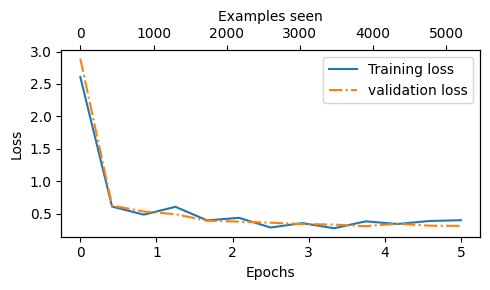

In [171]:
import matplotlib.pyplot as plt

def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
        label="loss"
):
    fig, ax1 = plt.subplots(figsize=(5,3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

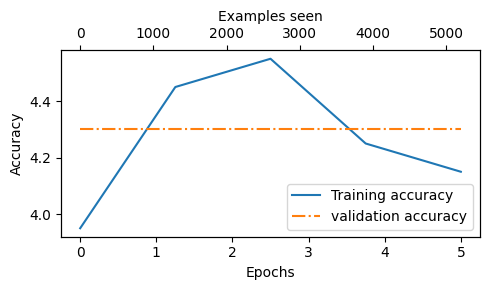

In [172]:
epochs_tensor = torch.linspace(0,num_epochs,len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(
    epochs_tensor, examples_seen_tensor,train_accs,val_accs, label="accuracy"
)

In [173]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(validation_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}")
print(f"Validation accuracy: {val_accuracy*100:.2f}")
print(f"Test accuracy: {test_accuracy*100:.2f}")

Training accuracy: 430.58
Validation accuracy: 442.28
Test accuracy: 410.67


In [174]:
def clasify_review(
        text, model, tokenizer, device, max_length=None,
        pad_token_id=50256
):
    model.eval()
    input_ids = tokenizer.encode(text)
    supported_context_length=model.pos_emb.weight.shape[1]

    input_ids = input_ids[:min(
        max_length, supported_context_length
    )]

    input_ids += [pad_token_id] * (max_length - len(input_ids))

    input_tensor = torch.tensor(
        input_ids, device=device
    ).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)[:,-1,:]
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [175]:
text_1 = (
    "you are a winner you have been specially"
    " selected to recieve $1000 cash or a $2000 award"
)
print(clasify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? let me know!"
)
print(clasify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam
not spam
